# Load Dataset

In [2]:
import pandas as pd

# Load the dataset
mortality_dataset = pd.read_csv('./datasets/Weekly_Provisional_Counts_of_Deaths_by_State_and_Select_Causes__2020-2023_20250216.csv')
mortality_dataset_illinois = mortality_dataset[mortality_dataset['Jurisdiction of Occurrence'] == 'Illinois']
climate_dataset = pd.read_csv('./datasets/Climate datasets/Data Cleaning/Climate_weekly_data.csv')


# count number of rows in both and print
print("Number of rows in mortality dataset: ", len(mortality_dataset_illinois))
print("Number of rows in climate dataset: ", len(climate_dataset))

climate_dataset.columns

Number of rows in mortality dataset:  194
Number of rows in climate dataset:  196


Index(['Week_Ending_Date', 'AWND', 'DAPR', 'MDPR', 'PRCP', 'SNOW', 'SNWD',
       'TAVG', 'TMAX', 'TMIN', 'TOBS', 'WT01', 'WT02', 'WT03', 'WT04', 'WT05',
       'WT06', 'WT08', 'WT11'],
      dtype='object')

# Data Pre-Processing

In [3]:
# Code for cleaning individiual datasets
relevent_mortality_columns = ['Jurisdiction of Occurrence', 'MMWR Year', 'MMWR Week',
       'Week Ending Date', 'All Cause', 'Natural Cause',
       'Septicemia (A40-A41)', 'Malignant neoplasms (C00-C97)',
       'Diabetes mellitus (E10-E14)', 'Alzheimer disease (G30)',
       'Influenza and pneumonia (J09-J18)',
       'Chronic lower respiratory diseases (J40-J47)',
       'Other diseases of respiratory system (J00-J06,J30-J39,J67,J70-J98)',
       'Nephritis, nephrotic syndrome and nephrosis (N00-N07,N17-N19,N25-N27)',
       'Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified (R00-R99)',
       'Diseases of heart (I00-I09,I11,I13,I20-I51)',
       'Cerebrovascular diseases (I60-I69)',
       'COVID-19 (U071, Multiple Cause of Death)',
       'COVID-19 (U071, Underlying Cause of Death)']
# Drop irrelevant columns from mortality dataset
mortality_dataset_illinois = mortality_dataset_illinois[relevent_mortality_columns]

relevant_climate_columns = ['Week_Ending_Date', 'AWND', 'DAPR', 'MDPR', 'PRCP', 'SNOW', 'SNWD',
       'TAVG', 'TMAX', 'TMIN', 'TOBS']

column_map = {
    'Week_Ending_Date': 'Week Ending Date',
    'AWND': 'Average Wind Speed (m/s)',
    'DAPR': 'Number of days included in the multiday precipitation total',
    'MDPR': 'Multiday precipitation total (mm)',
    'PRCP': 'Precipitation (mm)',
    'SNOW': 'Snowfall (cm)',
    'SNWD': 'Snow Depth (cm)',
    'TAVG': 'Average Temperature (C)',
    'TMAX': 'Maximum Temperature (C)',
    'TMIN': 'Minimum Temperature (C)',
    'TOBS': 'Temperature Observed (C)'
}

# Drop irrelevant columns from climate dataset
climate_dataset = climate_dataset[relevant_climate_columns]
# Rename columns in climate dataset
climate_dataset.rename(columns=column_map, inplace=True)

In [4]:
# Merge Columns
mortality_dataset_illinois['Week Ending Date'] = pd.to_datetime(mortality_dataset_illinois['Week Ending Date'])
climate_dataset['Week Ending Date'] = pd.to_datetime(climate_dataset['Week Ending Date'])
merged_dataset = pd.merge(mortality_dataset_illinois, climate_dataset, on='Week Ending Date', how='inner')

merged_dataset.head()

,Jurisdiction of Occurrence,MMWR Year,MMWR Week,Week Ending Date,All Cause,Natural Cause,Septicemia (A40-A41),Malignant neoplasms (C00-C97),Diabetes mellitus (E10-E14),Alzheimer disease (G30),...,Average Wind Speed (m/s),Number of days included in the multiday precipitation total,Multiday precipitation total (mm),Precipitation (mm),Snowfall (cm),Snow Depth (cm),Average Temperature (C),Maximum Temperature (C),Minimum Temperature (C),Temperature Observed (C)
0,Illinois,2020,1,2020-01-04,2191,2007,29.0,427.0,57.0,74.0,...,9.210750,6.612903,0.621724,0.020785,0.148594,0.318916,37.781250,43.290650,28.983640,33.682864
1,Illinois,2020,2,2020-01-11,2252,2080,47.0,477.0,65.0,93.0,...,11.422643,5.620000,0.729583,0.311628,0.010213,0.042903,37.642857,45.340987,26.728853,32.982684
2,Illinois,2020,3,2020-01-18,2231,2065,30.0,476.0,59.0,94.0,...,10.194357,3.543860,1.450536,0.161805,0.358374,0.545935,31.714286,37.518648,22.459837,28.558309
3,Illinois,2020,4,2020-01-25,2199,2033,33.0,447.0,72.0,87.0,...,9.213000,3.532468,0.620533,0.080188,0.324857,1.473982,25.700000,30.947248,17.700000,22.355301
4,Illinois,2020,5,2020-02-01,2137,1984,33.0,450.0,61.0,76.0,...,5.445500,4.186441,0.429825,0.014698,0.062847,1.513662,32.714286,34.669309,27.444824,29.648649


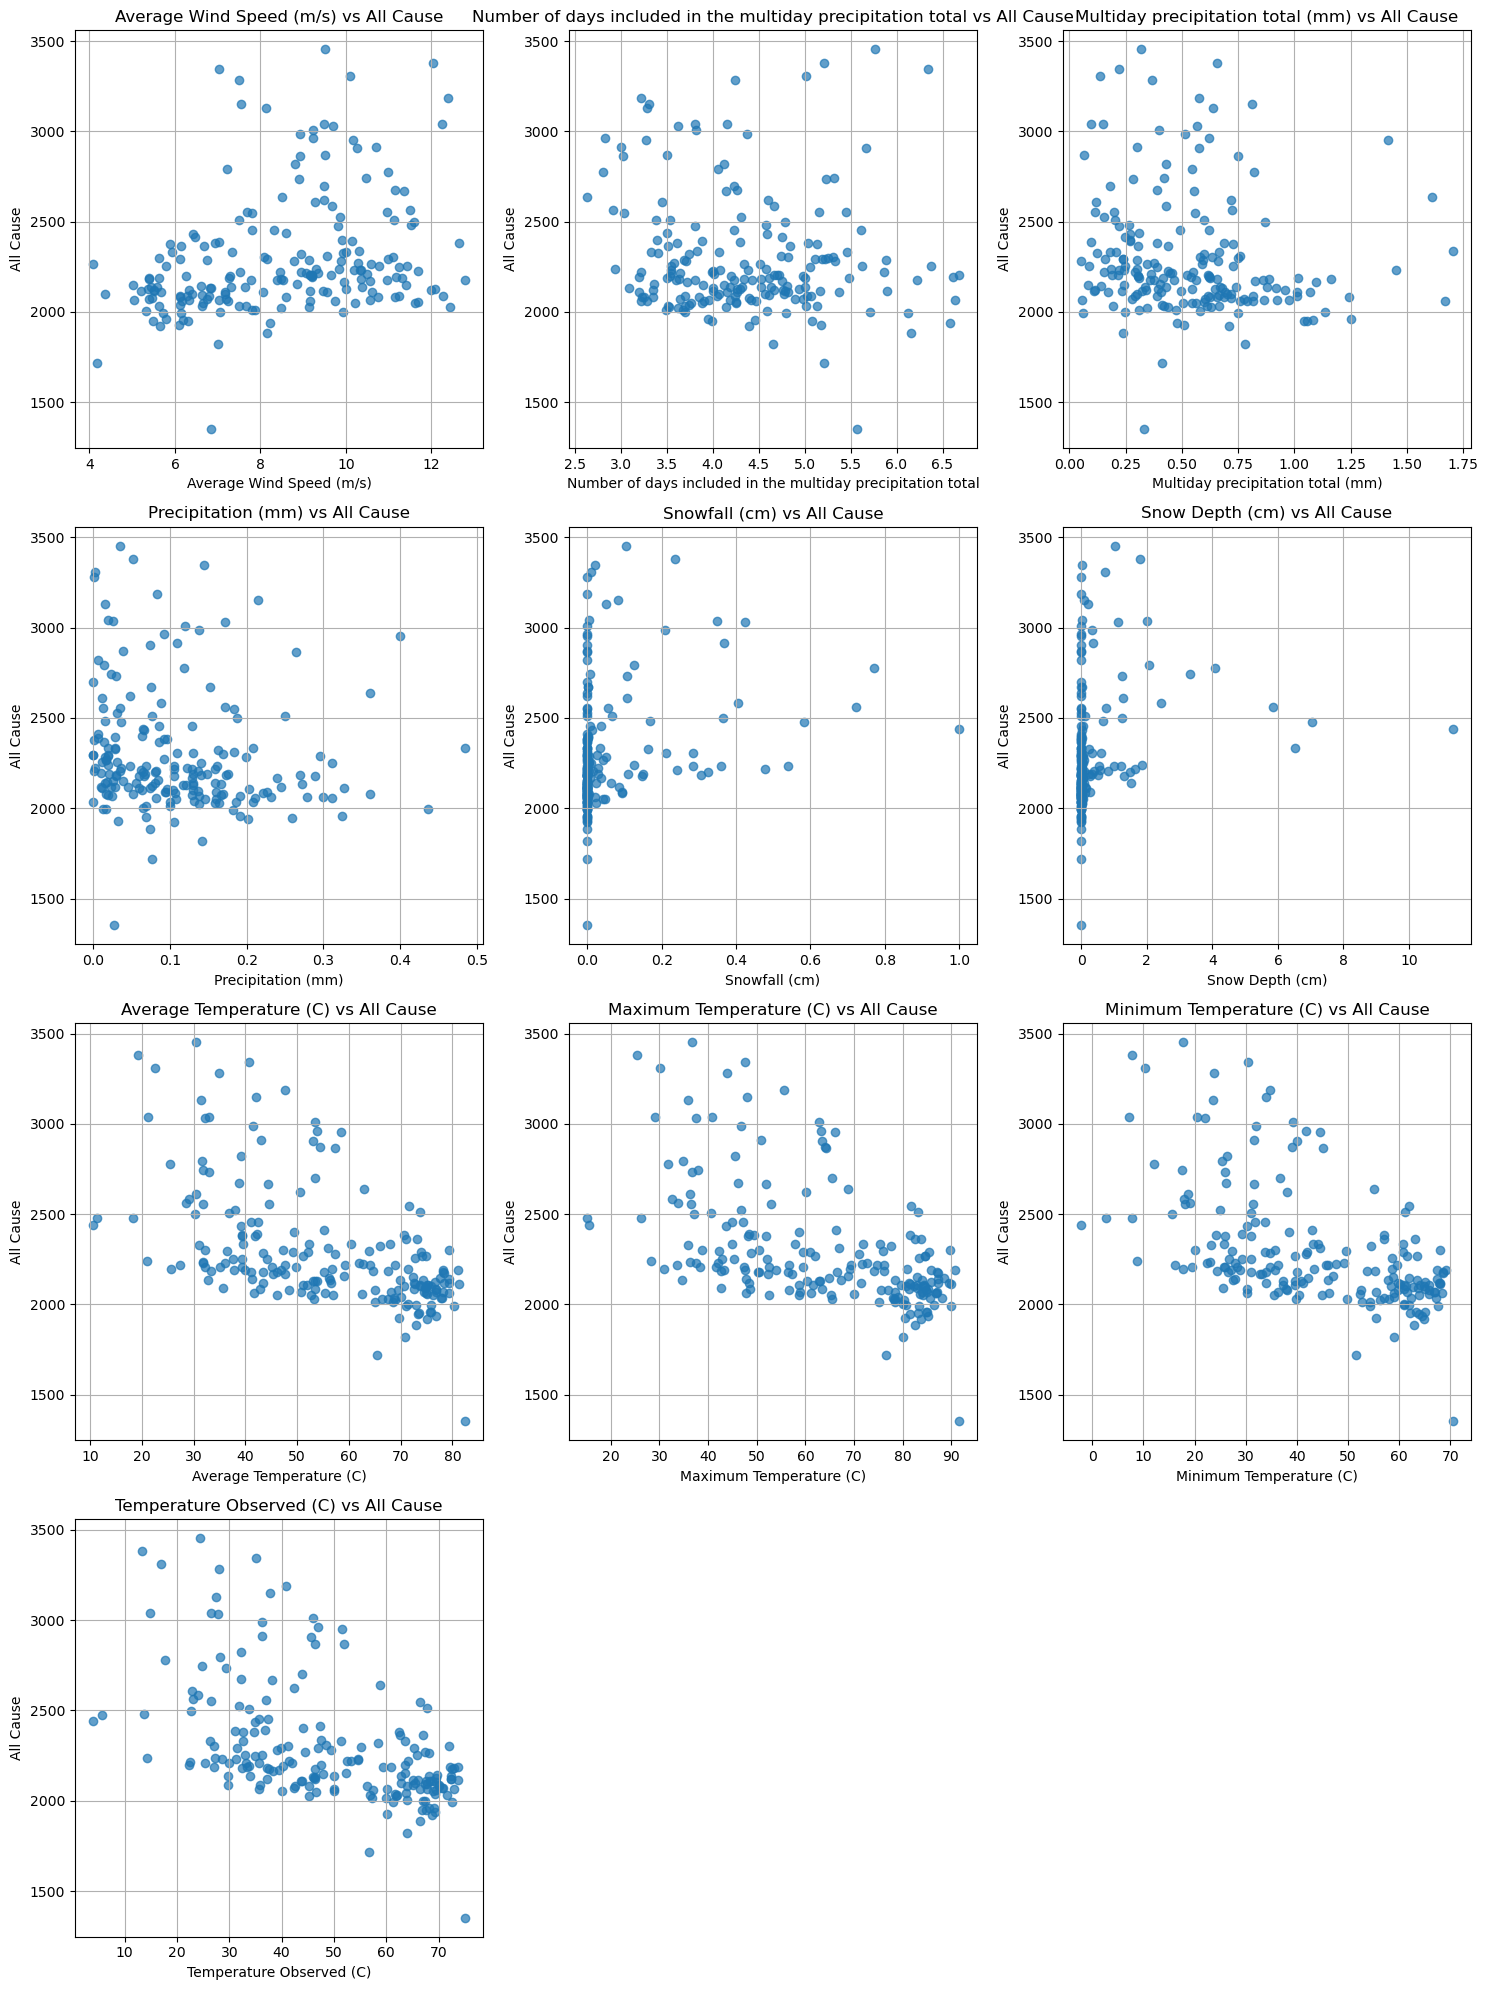

In [35]:
import math

import matplotlib.pyplot as plt

# Ensure "columns" is defined
columns = ['All Cause', 'Average Wind Speed (m/s)', 'Number of days included in the multiday precipitation total',
           'Multiday precipitation total (mm)', 'Precipitation (mm)', 'Snowfall (cm)', 'Snow Depth (cm)',
           'Average Temperature (C)', 'Maximum Temperature (C)', 'Minimum Temperature (C)', 'Temperature Observed (C)']

# Remove "All Cause" from columns as it's the target variable
features = [col for col in columns if col != 'All Cause']

# Determine grid size
n_features = len(features)
n_cols = 3  # Number of columns in the grid
n_rows = math.ceil(n_features / n_cols)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

# Plot each feature
for i, column in enumerate(features):
    ax = axes[i]
    ax.scatter(merged_dataset[column], merged_dataset['All Cause'], alpha=0.7)
    ax.set_xlabel(column)
    ax.set_ylabel('All Cause')
    ax.set_title(f'{column} vs All Cause')
    ax.grid()

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


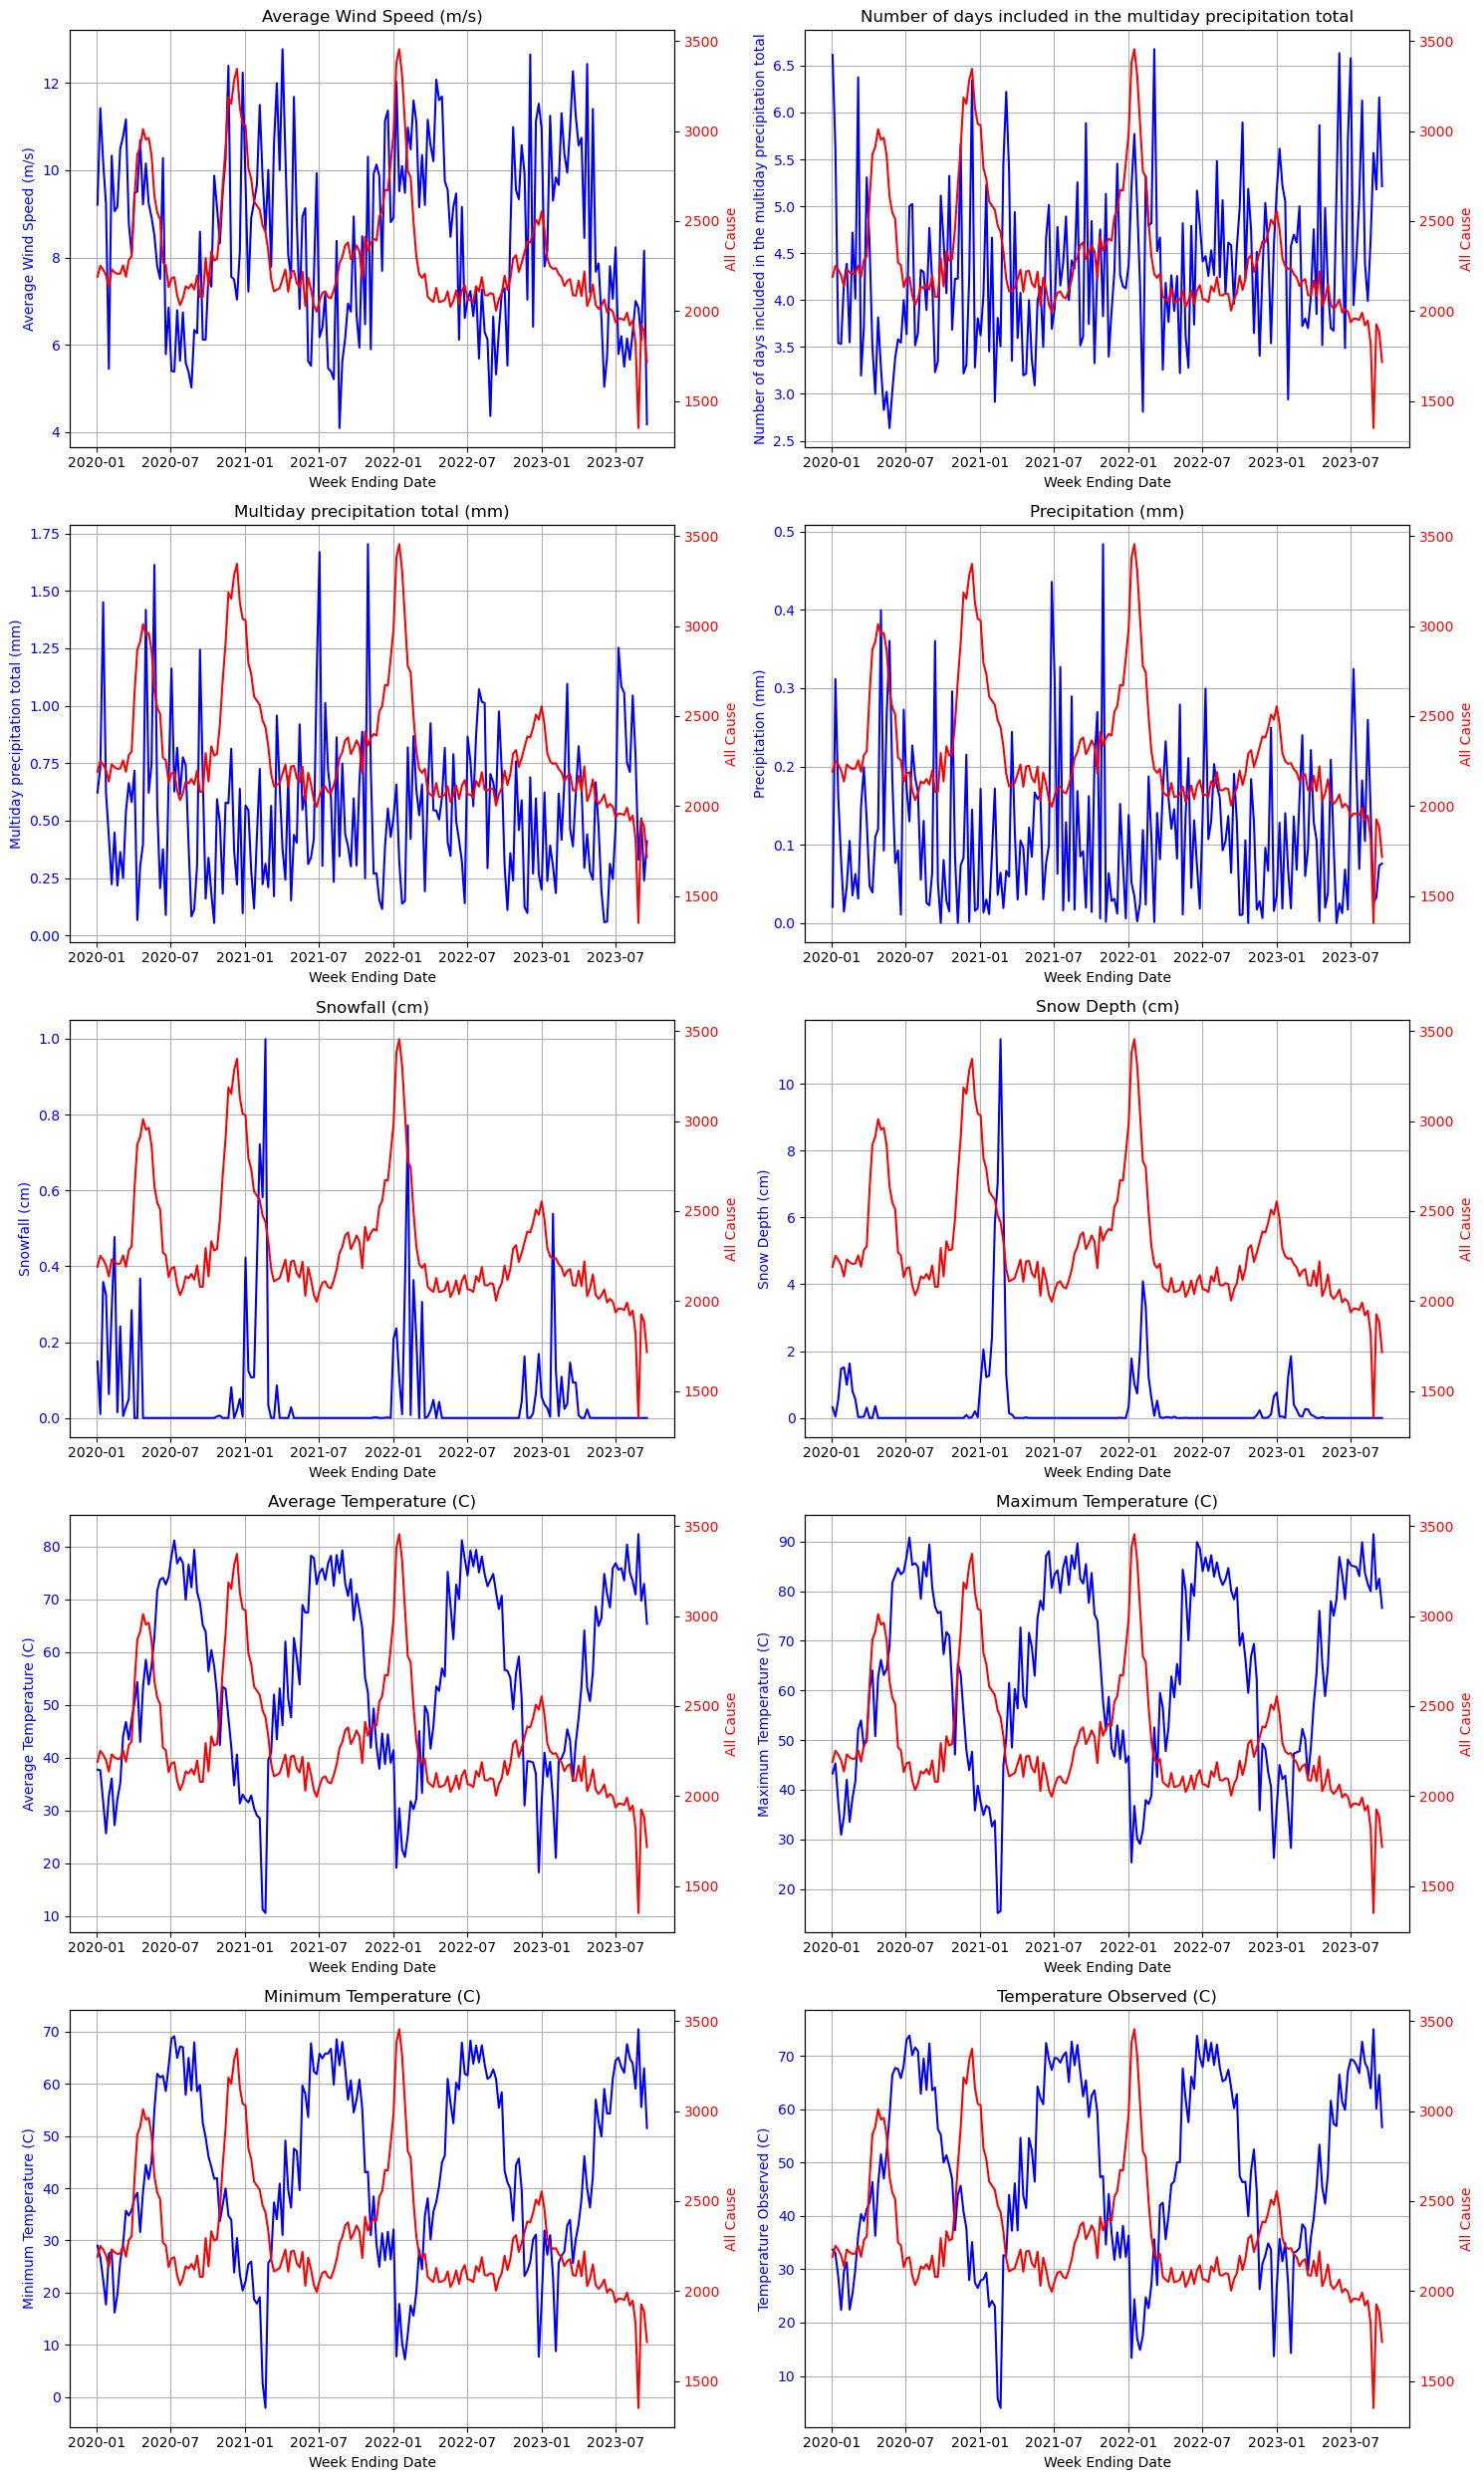

In [43]:
label = ['All Cause']

features = ['Average Wind Speed (m/s)', 'Number of days included in the multiday precipitation total',
           'Multiday precipitation total (mm)', 'Precipitation (mm)', 'Snowfall (cm)', 'Snow Depth (cm)',
           'Average Temperature (C)', 'Maximum Temperature (C)', 'Minimum Temperature (C)', 'Temperature Observed (C)']

# Determine grid size
n_features = len(features)
n_cols = 2 
n_rows = math.ceil(n_features / n_cols)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

# Plot each feature
for i, column in enumerate(features):
    ax = axes[i]
    ax.plot(merged_dataset['Week Ending Date'], merged_dataset[column], color='blue', label=column)
    ax.set_xlabel('Week Ending Date')
    ax.set_ylabel(column, color='blue')
    ax.tick_params(axis='y', labelcolor='blue')
    ax.set_title(f'{column}')
    ax.grid()

    # Create a twin y-axis for 'All Cause'
    ax2 = ax.twinx()
    ax2.plot(merged_dataset['Week Ending Date'], merged_dataset['All Cause'], color='red', label='All Cause')
    ax2.set_ylabel('All Cause', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# Correlation

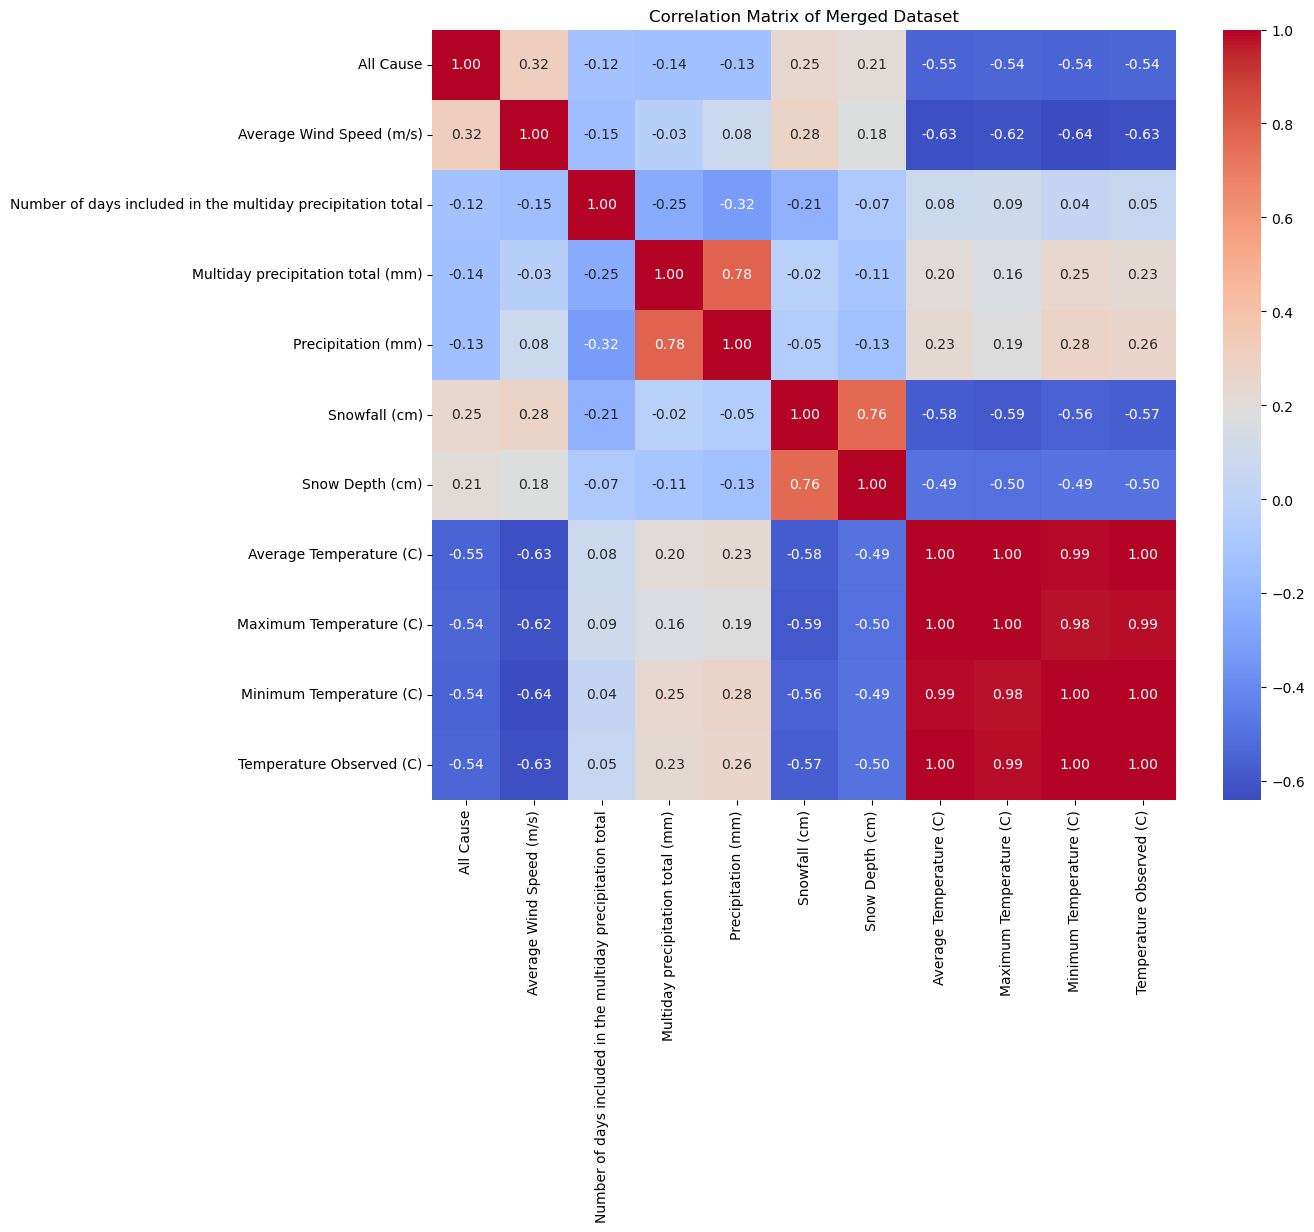

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt


# Compute the correlation matrix for numeric columns only and only All Cause
columns = ['All Cause', 'Average Wind Speed (m/s)', 'Number of days included in the multiday precipitation total',
           'Multiday precipitation total (mm)', 'Precipitation (mm)', 'Snowfall (cm)', 'Snow Depth (cm)',
           'Average Temperature (C)', 'Maximum Temperature (C)', 'Minimum Temperature (C)', 'Temperature Observed (C)']
correlation_matrix = merged_dataset[columns].corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Merged Dataset")
plt.show()

# Feature Engineering

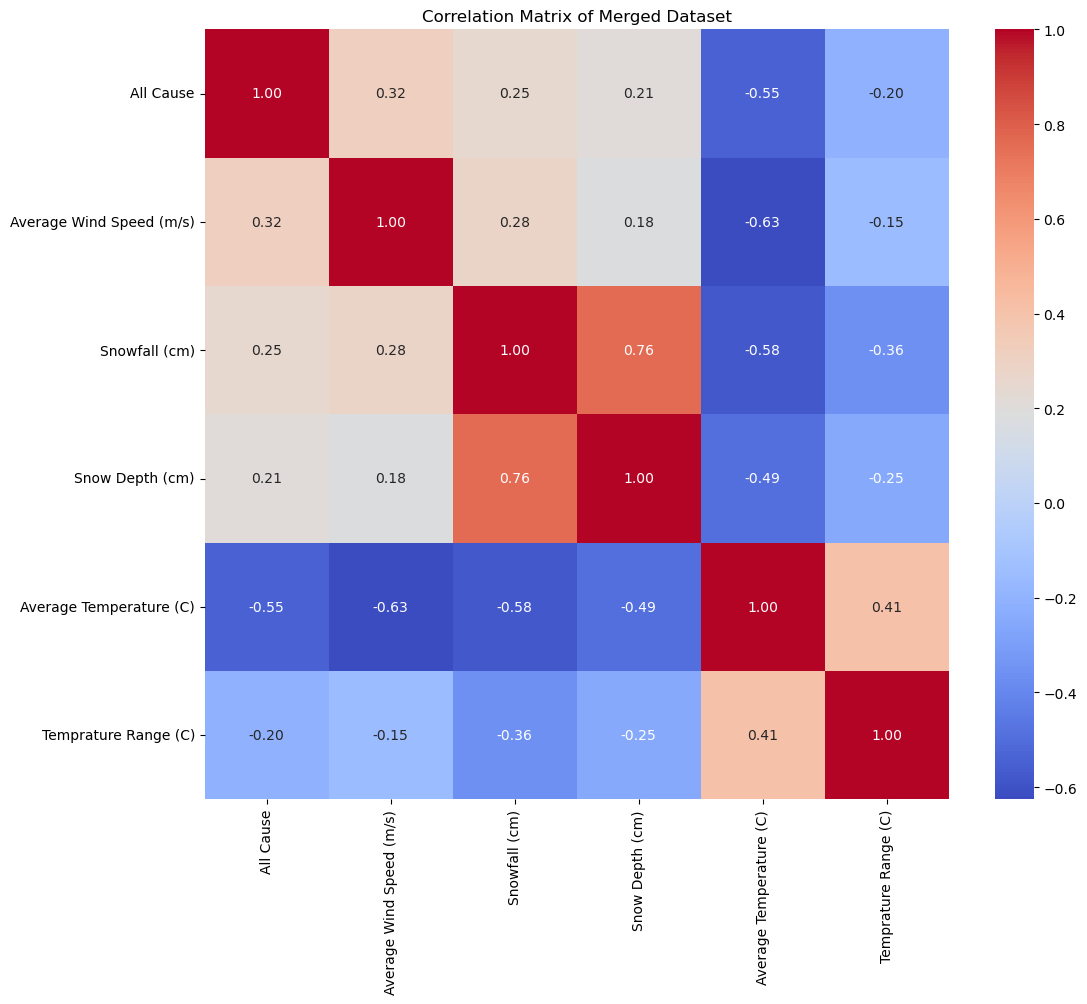

In [ ]:
merged_dataset['Temprature Range (C)'] = merged_dataset['Maximum Temperature (C)'] - merged_dataset['Minimum Temperature (C)']

columns = ['All Cause', 'Average Wind Speed (m/s)', 'Snowfall (cm)', 'Snow Depth (cm)',
           'Average Temperature (C)', 'Temprature Range (C)']

correlation_matrix = merged_dataset[columns].corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Merged Dataset")
plt.show()

# Linear Model 

In [32]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
import numpy as np

predictors = ['Average Wind Speed (m/s)', 'Snowfall (cm)', 'Snow Depth (cm)',
              'Average Temperature (C)', 'Temprature Range (C)']
label = 'All Cause'

X = merged_dataset[predictors]
y = merged_dataset[label]

# Optional: Standardize features before polynomial expansion
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Add polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_scaled)

# Perform RFECV with Ridge
ridge = Ridge(alpha=1.0)
rfecv = RFECV(estimator=ridge, step=1, cv=5, scoring='r2')
rfecv.fit(X_poly, y)

# Selected features
selected_features = rfecv.support_
selected_feature_names = [name for name, selected in zip(poly.get_feature_names_out(predictors), selected_features) if selected]
X_selected = X_poly[:, selected_features]

# Cross-validation R² scores
cv_scores = cross_val_score(ridge, X_selected, y, cv=5, scoring='r2')
mean_r2 = cv_scores.mean()

# Fit final model to compute adjusted R²
ridge.fit(X_selected, y)
y_pred = ridge.predict(X_selected)
r2 = r2_score(y, y_pred)
n, p = X_selected.shape
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Output
print("Selected Features:", selected_feature_names)
print("Cross-Validation R² Scores:", cv_scores)
print("Mean R² Score:", mean_r2)
print("Adjusted R² Score (on full data):", adjusted_r2)


Selected Features: ['Average Temperature (C)']
Cross-Validation R² Scores: [-0.43513456  0.16311516  0.24266939 -0.33997726 -1.21027615]
Mean R² Score: -0.31592068293957853
Adjusted R² Score (on full data): 0.2963050553847123


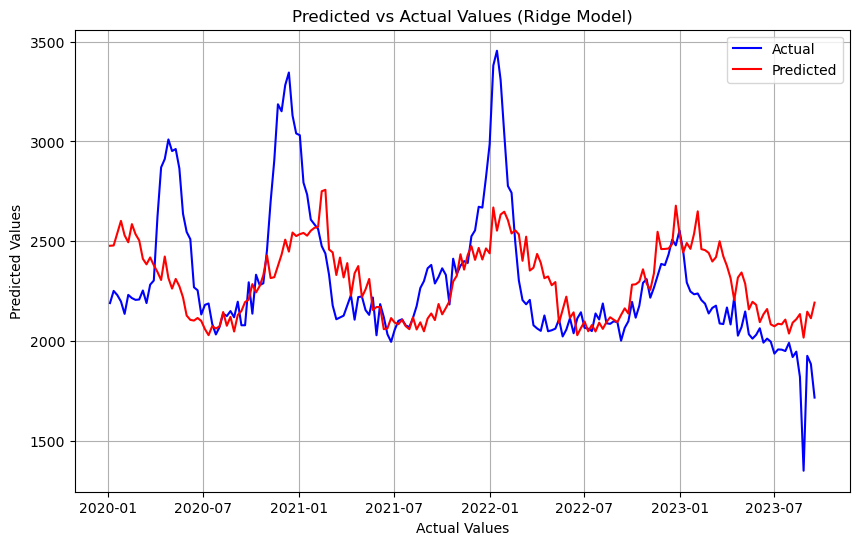

In [45]:
import matplotlib.pyplot as plt

# Plot predicted vs actual values
plt.figure(figsize=(10, 6))
plt.plot(merged_dataset['Week Ending Date'], merged_dataset['All Cause'], label='Actual', color='blue')
plt.plot(merged_dataset['Week Ending Date'], y_pred, label='Predicted', color='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values (Ridge Model)')
plt.legend()
plt.grid()
plt.show()

# ARIMA Model to forecast Death Count

23:38:21 - cmdstanpy - INFO - Chain [1] start processing
23:38:21 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\mohi2\.conda\envs\prompter\lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\mohi2\.conda\envs\prompter\lib\site-packages\prophet\plot.py:397: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
c:\Users\mohi2\.conda\envs\prompter\lib\site-packages\prophet\plot.py:401: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is 

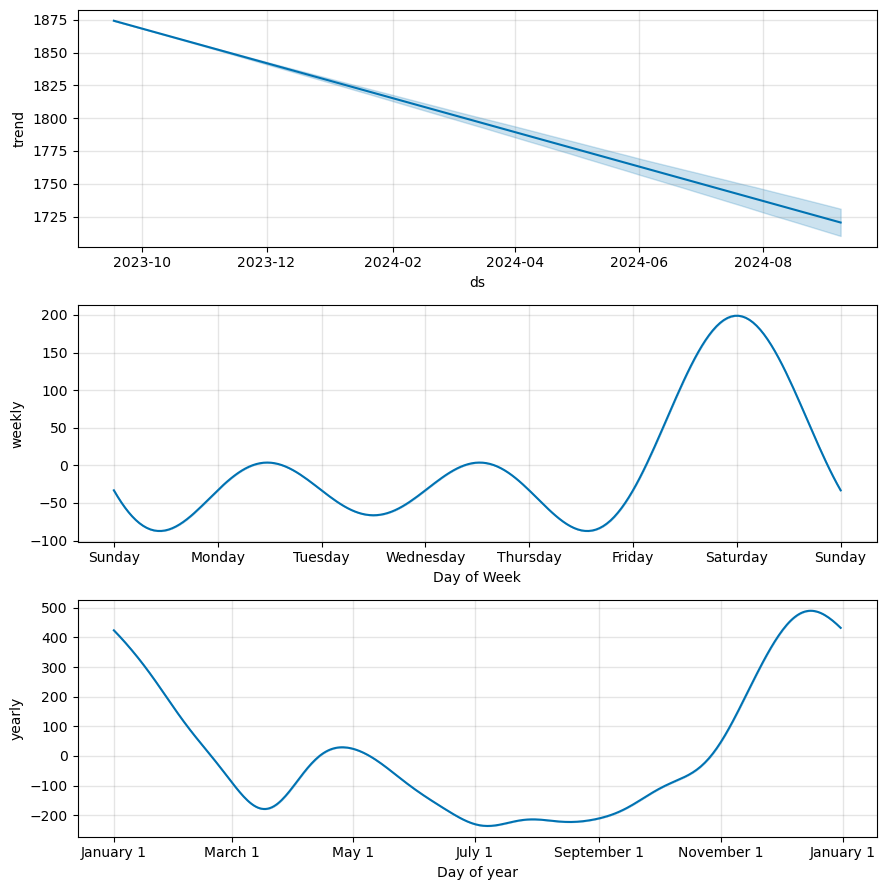

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/32 [00:00<?, ?it/s]23:38:22 - cmdstanpy - INFO - Chain [1] start processing
23:38:23 - cmdstanpy - INFO - Chain [1] done processing
  3%|▎         | 1/32 [00:00<00:14,  2.09it/s]23:38:23 - cmdstanpy - INFO - Chain [1] start processing
23:38:23 - cmdstanpy - INFO - Chain [1] done processing
  6%|▋         | 2/32 [00:01<00:15,  1.95it/s]23:38:23 - cmdstanpy - INFO - Chain [1] start processing
23:38:24 - cmdstanpy - INFO - Chain [1] done processing
  9%|▉         | 3/32 [00:01<00:16,  1.78it/s]23:38:24 - cmdstanpy - INFO - Chain [1] start processing
23:38:24 - cmdstanpy - INFO - Chain [1] done processing
 12%|█▎        | 4/32 [00:02<00:16,  1.66it/s]23:38:25 - cmdstanpy - INFO - Chain [1] start processing
23:38:25 - cmdstanpy - INFO - Chain [1] done processing
 16%|█▌        | 5/32 [00:03<00:18,  1.48it/s]23:38:25 - cmdstanpy - INFO - Chain [1] start processing
23:38:

  horizon           mse        rmse         mae      mape     mdape     smape  \
0  3 days  33639.983961  183.412061  142.756929  0.064749  0.052129  0.063530   
1  4 days  44336.444233  210.562210  177.328269  0.080185  0.065304  0.078008   
2  5 days  61255.696595  247.498882  204.858828  0.089461  0.083378  0.090950   
3  6 days  78071.822171  279.413354  241.539118  0.105445  0.095611  0.103976   
4  7 days  91288.286444  302.139515  257.780688  0.109687  0.095611  0.111954   

   coverage  
0  0.784615  
1  0.707692  
2  0.615385  
3  0.492308  
4  0.461538  


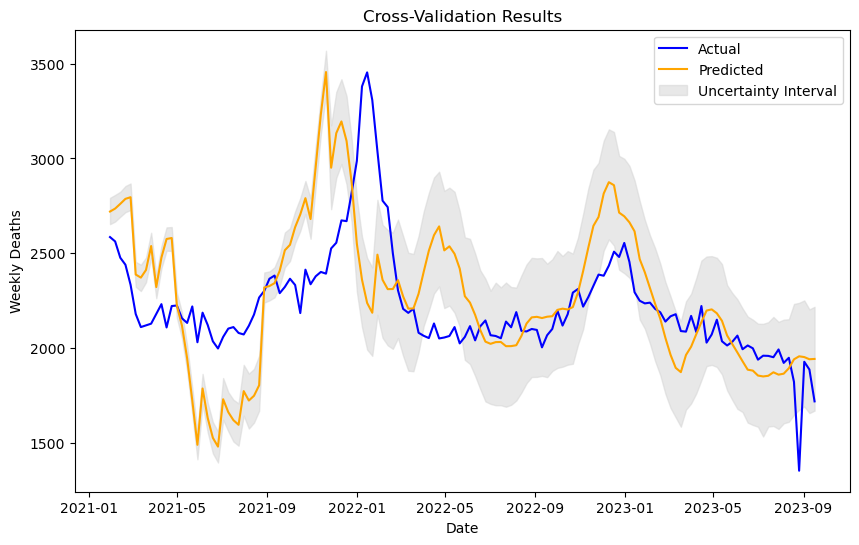

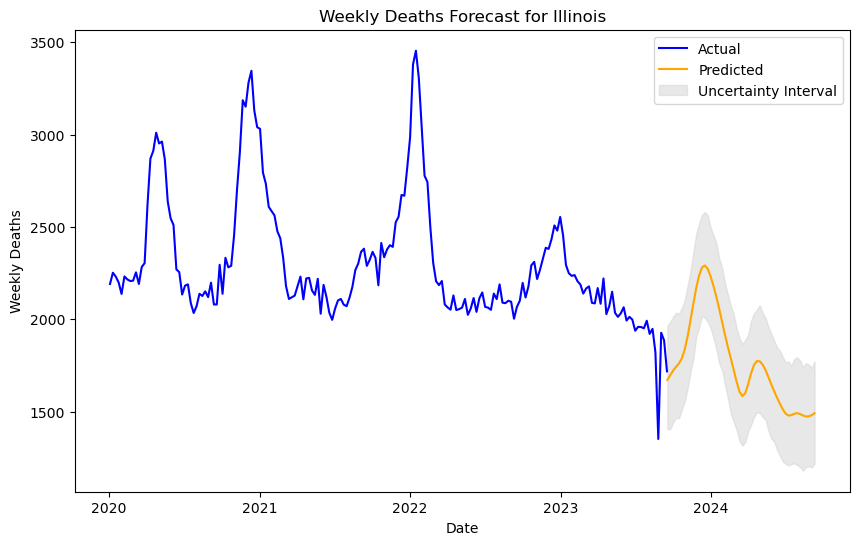

In [ ]:
from prophet import Prophet
from datetime import datetime
from prophet.plot import plot_plotly
from prophet.diagnostics import cross_validation, performance_metrics


# Convert the date column to datetime format
mortality_dataset_illinois['Week Ending Date'] = pd.to_datetime(mortality_dataset_illinois['Week Ending Date'], errors='coerce')
mortality_dataset_illinois.dropna(subset=['Week Ending Date'], inplace=True)  # Drop rows with invalid dates
mortality_dataset_illinois.rename(columns={'Week Ending Date': 'ds', 'All Cause': 'y'}, inplace=True)
mortality_dataset_illinois = mortality_dataset_illinois[['ds', 'y']].dropna()
mortality_dataset_illinois = mortality_dataset_illinois[(mortality_dataset_illinois['y'] > 0) & (mortality_dataset_illinois['y'] < 10000)]  # Filter rows with valid 'y' values

# Create a Prophet model
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
model.fit(mortality_dataset_illinois)

# Create a future dataframe for predictions
future = model.make_future_dataframe(periods=52, freq='W')
future = future[future['ds'] > mortality_dataset_illinois['ds'].max()]
future = future[future['ds'] < mortality_dataset_illinois['ds'].max() + pd.DateOffset(weeks=52)]

# Make predictions
forecast = model.predict(future)

# Plot the forecast components
fig2 = model.plot_components(forecast)
plt.show()
# Cross-validation
df_cv = cross_validation(model, initial='365 days', period='30 days', horizon='30 days')
df_p = performance_metrics(df_cv)
print(df_p.head())
# Plot the cross-validation results
plt.figure(figsize=(10, 6))
plt.plot(df_cv['ds'], df_cv['y'], label='Actual', color='blue')
plt.plot(df_cv['ds'], df_cv['yhat'], label='Predicted', color='orange')
plt.fill_between(df_cv['ds'], df_cv['yhat_lower'], df_cv['yhat_upper'], color='lightgray', alpha=0.5, label='Uncertainty Interval')
plt.xlabel('Date')
plt.ylabel('Weekly Deaths')
plt.title('Cross-Validation Results')
plt.legend()
plt.show()

# Plot the forecast with uncertainty intervals
plt.figure(figsize=(10, 6))
plt.plot(mortality_dataset_illinois['ds'], mortality_dataset_illinois['y'], label='Actual', color='blue')
plt.plot(forecast['ds'], forecast['yhat'], label='Predicted', color='orange')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='lightgray', alpha=0.5, label='Uncertainty Interval')
plt.xlabel('Date')
plt.ylabel('Weekly Deaths')
plt.title('Weekly Deaths Forecast for Illinois')
plt.legend()
plt.show()